In [85]:
import streamlit as st
from langchain.chains import LLMChain, SimpleSequentialChain
import pandas as pd
import sqlite3
import os
from dotenv import load_dotenv
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI
from subs.db_connections import connetc_to_irish_db

load_dotenv()
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

# Check current working directory.
print("Current Working Directory: ", os.getcwd())


# #llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)
db = connetc_to_irish_db()



Current Working Directory:  /Users/saeed/Documents/GitHub/ireland_res_chatbot


In [2]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    FewShotPromptTemplate,
    MessagesPlaceholder,
    PromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_openai import OpenAIEmbeddings
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_community.vectorstores import FAISS
from typing import List
from subs.agent import configure_sequential_chain
from subs.agent import sql_agent
from subs.agent import invoke_full_prompt
# Invoke the full prompt for the SQL chain using the provided SQL chain ID


prompt_for_sql = invoke_full_prompt(chain_id="chain_1")

# Create the SQL agent chain with the generated prompt
chain_sql = sql_agent(prompt=prompt_for_sql)


In [3]:
chain_final = SimpleSequentialChain(
        chains=[chain_sql], verbose=True
    )

In [80]:
response_of_chain = chain_final.run("Can you tell me about IE SNSP from 2015 to 2023 averaged per month, preferably in a line chart?")



> Entering new SimpleSequentialChain chain...


> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': "SELECT strftime('%Y-%m', `DateTime`) AS Month, AVG(`IE SNSP`) AS `Average IE SNSP` FROM energy_data WHERE `DateTime` >= '2015-01-01' AND `DateTime` < '2024-01-01' GROUP BY Month ORDER BY Month ASC;"}`


Error: (sqlite3.OperationalError) no such column: IE SNSP
[SQL: SELECT strftime('%Y-%m', `DateTime`) AS Month, AVG(`IE SNSP`) AS `Average IE SNSP` FROM energy_data WHERE `DateTime` >= '2015-01-01' AND `DateTime` < '2024-01-01' GROUP BY Month ORDER BY Month ASC;]
(Background on this error at: https://sqlalche.me/e/14/e3q8)
Invoking: `sql_db_schema` with `{'table_names': 'energy_data'}`



CREATE TABLE energy_data (
	"DateTime" TEXT, 
	"NI Generation" REAL, 
	"NI Demand" REAL, 
	"NI Wind Availability" REAL, 
	"NI Wind Generation" REAL, 
	"IE Generation" REAL, 
	"IE Demand" REAL, 
	"IE Wind Availability" REAL, 
	"IE Wind Generation" REAL, 
	"SNSP" REAL, 
	

In [81]:
response_of_chain

'Here are the monthly averages of the System Non-Synchronous Penetration (SNSP) for the Republic of Ireland from 2015 to 2023:\n\n- **2015**\n  - January: 0.351\n  - February: 0.270\n  - March: 0.294\n  - April: 0.220\n  - May: 0.296\n  - June: 0.234\n  - July: 0.233\n  - August: 0.191\n  - September: 0.190\n  - October: 0.195\n  - November: 0.322\n  - December: 0.367\n\n- **2016**\n  - January: 0.304\n  - February: 0.272\n  - March: 0.217\n  - April: 0.198\n  - May: 0.182\n  - June: 0.144\n  - July: 0.150\n  - August: 0.214\n  - September: 0.230\n  - October: 0.191\n  - November: 0.191\n  - December: 0.282\n\n- **2017**\n  - January: 0.249\n  - February: 0.333\n  - March: 0.293\n  - April: 0.207\n  - May: 0.198\n  - June: 0.261\n  - July: 0.182\n  - August: 0.205\n  - September: 0.258\n  - October: 0.332\n  - November: 0.281\n  - December: 0.328\n\n- **2018**\n  - January: 0.419\n  - February: 0.360\n  - March: 0.320\n  - April: 0.314\n  - May: 0.244\n  - June: 0.182\n  - July: 0.184\

In [82]:
user_query = "Can you tell me about IE SNSP from 2015 to 2023 averaged per month, preferably in a line chart?"
plot_data = response_of_chain

In [83]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Set up the chat model
chat = ChatOpenAI(model="gpt-4-turbo", temperature=0)

# Define a system message and the user prompt
system_message = SystemMessage(content=(
    "You are an expert in generating Python plotting scripts using matplotlib. "
    "You'll receive a user query and a dataset. Understand the user query to detect the preferred chart type. "
    "Please handle any `None` values by replacing them with zero before plotting."
    "If the query mentions 'bar chart' or 'line chart', use that type. Otherwise, default to a bar chart. "
    "In bar chart, if multiple data series exist, group the bars for each category to represent the different series side by side. "
    "Generate a Python script that uses matplotlib to visualize the data with appropriate axis labels, title, and legend."
    "The output must contain only the Python code itself to be used in executable with no changes. "
    "Do not include markdown code fences, additional comments, text, or use the `\\n` character explicitly to separate lines."
))

# Provide the user prompt, including the dataset and initial query
user_prompt = (
    f'Given the user query: "{user_query}" and the following dataset:\n\n'
    f'{plot_data}\n\n'
    "Create a Python script to visualize this data with matplotlib. Make sure to detect the correct chart type and apply "
    "appropriate axis labels, a title, and a legend."
)

# Call the chat model to generate the code
messages = [
    system_message,
    HumanMessage(content=user_prompt)
]
response = chat(messages)

# Extract the generated code from the response
generated_code = response.content.strip()




In [74]:


examples = [
            {
                "input": "Calculate the solar curtailment for Northern Ireland on 2023-04-05.",
                "query": "SELECT `NI Solar Availability` - `NI Solar Generation` AS SolarCurtailment FROM energy_data WHERE `DateTime` = '2023-04-05';",
            },
            {
                "input": "What was the wind penetration for the island of Ireland on 2023-01-20?",
                "query": "SELECT (SUM(`IE Wind Generation` + `NI Wind Generation`)) / SUM(`IE Demand` + `NI Demand`) AS WindPenetration FROM energy_data WHERE `DateTime` = '2023-01-20';",
            },
            {
                "input": "List the energy demand for the Republic of Ireland and Northern Ireland separately on 2023-03-10.",
                "query": "SELECT `IE Demand`, `NI Demand` FROM energy_data WHERE `DateTime` = '2023-03-10';",
            },
            {
                "input": "Find the total wind generation for the island of Ireland in February 2023.",
                "query": "SELECT SUM(`IE Wind Generation` + `NI Wind Generation`) FROM energy_data WHERE `DateTime` LIKE '2023-02%';",
            },

        ]


def few_shot_prompt_(chain_id: str) -> FewShotPromptTemplate:
    """
    Generates a FewShotPromptTemplate for a specified chain.

    Args:
        chain_id (str): Identifier for the chain to generate the prompt for.

    Returns:
        FewShotPromptTemplate: A template configured for the specified chain.
    """
    return FewShotPromptTemplate(
        example_selector=example_selector(chain_id),
        example_prompt=PromptTemplate.from_template(
            "User input: {input}\nSQL query: {query}"
        ),
        input_variables=["input", "dialect", "top_k"],
        prefix=system_prefix(chain_id),
        suffix="",
    )


system_message_prompt = SystemMessagePromptTemplate(
    prompt=few_shot_prompt_()
)

# Construct the full prompt template with the system message, the user's query, and a placeholder for the agent's scratchpad.
full_prompt = ChatPromptTemplate.from_messages(
    [
        system_message_prompt,
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)



"import matplotlib.pyplot as plt\n\n# Data\nmonths = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']\naverage_ie_demand = [3964.72, 3895.09, 3945.77, 3670.55, 3505.98, 3439.04, 3406.73, 3446.16, 3566.63, 3701.02, 3986.07, 4006.10]\naverage_ie_wind_generation = [1591.65, 1615.69, 1489.83, 1278.94, 749.41, 732.02, 1148.54, 1165.22, 1163.52, 1096.80, 1549.91, 2047.16]\n\n# Replace None values with zero (if any)\naverage_ie_demand = [0 if v is None else v for v in average_ie_demand]\naverage_ie_wind_generation = [0 if v is None else v for v in average_ie_wind_generation]\n\n# Plotting\nplt.figure(figsize=(10, 5))\nplt.plot(months, average_ie_demand, label='Average IE Demand (MW)', marker='o')\nplt.plot(months, average_ie_wind_generation, label='Average IE Wind Generation (MW)', marker='o')\n\n# Adding titles and labels\nplt.title('Monthly Averages for Irish Demand and Wind Generation in 2023')\nplt.xlabel(

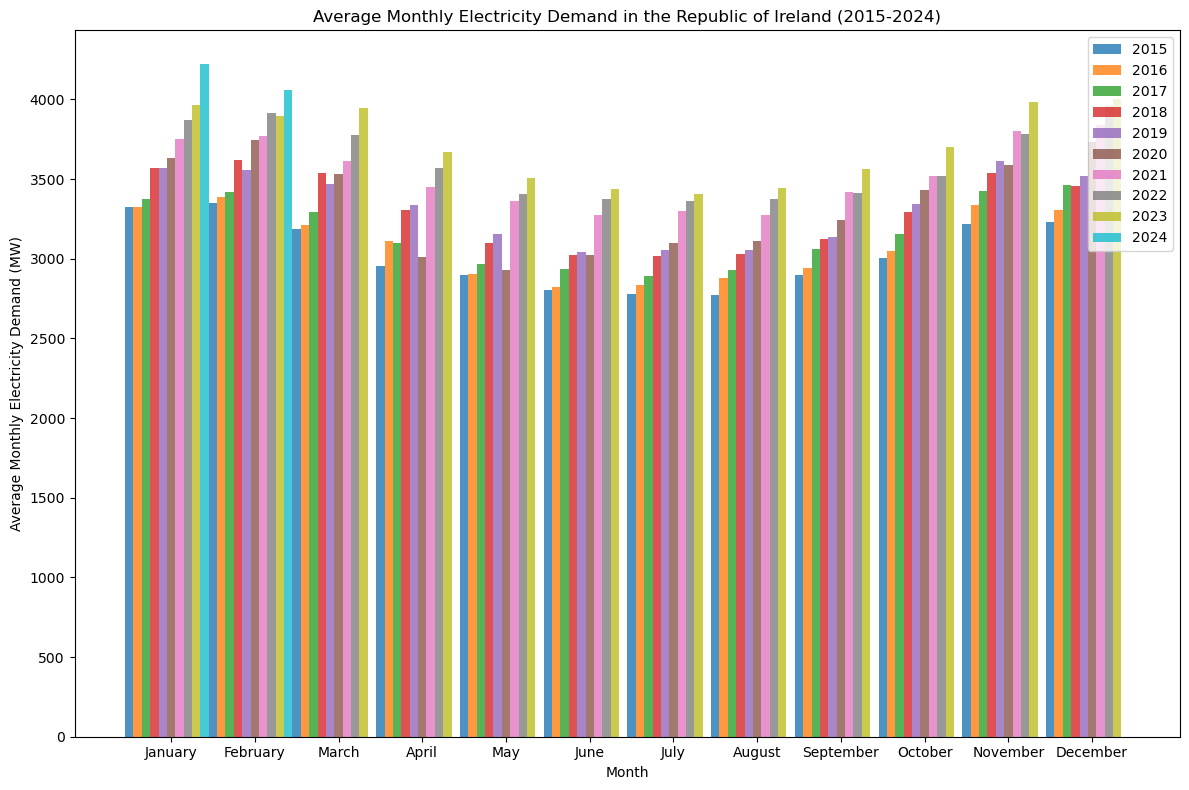

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Data
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data = {
    '2015': [3323.09, 3352.81, 3184.11, 2957.75, 2898.45, 2806.45, 2781.24, 2769.94, 2896.21, 3007.33, 3220.30, 3230.20],
    '2016': [3328.05, 3386.33, 3213.92, 3109.82, 2903.81, 2823.95, 2833.04, 2879.54, 2940.70, 3048.38, 3340.14, 3303.90],
    '2017': [3375.38, 3419.41, 3296.83, 3100.87, 2964.37, 2938.46, 2893.12, 2931.84, 3059.51, 3154.64, 3423.07, 3465.22],
    '2018': [3570.08, 3621.15, 3539.29, 3303.98, 3096.44, 3025.21, 3017.02, 3029.48, 3125.32, 3291.30, 3536.72, 3458.05],
    '2019': [3569.81, 3558.19, 3467.80, 3339.57, 3154.31, 3043.68, 3058.07, 3054.80, 3137.58, 3341.72, 3615.00, 3517.65],
    '2020': [3632.61, 3746.07, 3529.15, 3011.87, 2927.05, 3021.21, 3097.92, 3114.33, 3245.25, 3430.17, 3589.08, 3734.94],
    '2021': [3751.32, 3770.26, 3614.08, 3450.60, 3359.76, 3272.31, 3301.98, 3276.88, 3417.59, 3517.36, 3801.73, 3840.85],
    '2022': [3873.02, 3914.30, 3776.05, 3572.39, 3409.07, 3374.90, 3361.20, 3376.09, 3415.31, 3521.34, 3786.26, 3957.65],
    '2023': [3964.72, 3895.09, 3945.77, 3670.55, 3505.98, 3439.04, 3406.73, 3446.16, 3566.63, 3701.02, 3986.07, 4006.10],
    '2024': [4222.89, 4057.18, None, None, None, None, None, None, None, None, None, None]
}

# Replace None with zero
for year in data:
    data[year] = [0 if v is None else v for v in data[year]]

# Prepare data for plotting
num_years = len(years)
index = np.arange(len(months[:12]))  # Only up to February for 2024
bar_width = 0.1
opacity = 0.8

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for i, year in enumerate(years):
    plt.bar(index + i * bar_width, data[year][:len(months[:12])], bar_width, alpha=opacity, label=year)

# Labeling
plt.xlabel('Month')
plt.ylabel('Average Monthly Electricity Demand (MW)')
plt.title('Average Monthly Electricity Demand in the Republic of Ireland (2015-2024)')
plt.xticks(index + bar_width * num_years / 2, months[:12])
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [76]:
generated_code

"import matplotlib.pyplot as plt\n\n# Data\nmonths = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']\naverage_ie_demand = [3964.72, 3895.09, 3945.77, 3670.55, 3505.98, 3439.04, 3406.73, 3446.16, 3566.63, 3701.02, 3986.07, 4006.10]\naverage_ie_wind_generation = [1591.65, 1615.69, 1489.83, 1278.94, 749.41, 732.02, 1148.54, 1165.22, 1163.52, 1096.80, 1549.91, 2047.16]\n\n# Replace None values with zero (if any)\naverage_ie_demand = [0 if v is None else v for v in average_ie_demand]\naverage_ie_wind_generation = [0 if v is None else v for v in average_ie_wind_generation]\n\n# Plotting\nplt.figure(figsize=(10, 5))\nplt.plot(months, average_ie_demand, label='Average IE Demand (MW)', marker='o')\nplt.plot(months, average_ie_wind_generation, label='Average IE Wind Generation (MW)', marker='o')\n\n# Adding titles and labels\nplt.title('Monthly Averages for Irish Demand and Wind Generation in 2023')\nplt.xlabel(

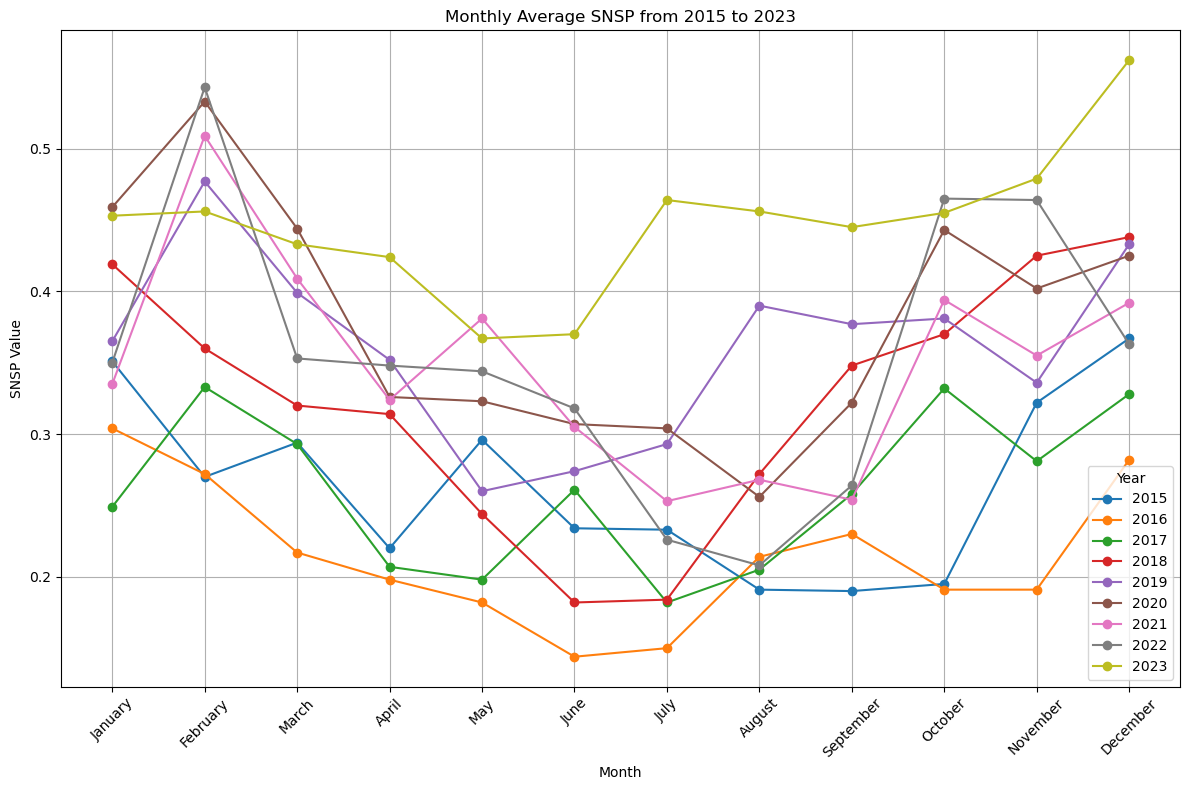

<ExecutionResult object at 2801156c0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 280115c60, raw_cell="import matplotlib.pyplot as plt

# Data
years = ['.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [84]:
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline

# Create an InteractiveShell instance
shell = InteractiveShell.instance()

# Execute the generated code
shell.run_cell(generated_code)

In [79]:
plot_data

'Here are the monthly averages for Irish demand and wind generation in 2023:\n\n| Month   | Average IE Demand | Average IE Wind Generation |\n|---------|-------------------|----------------------------|\n| 2023-01 | 3964.72 MW        | 1591.65 MW                 |\n| 2023-02 | 3895.09 MW        | 1615.69 MW                 |\n| 2023-03 | 3945.77 MW        | 1489.83 MW                 |\n| 2023-04 | 3670.55 MW        | 1278.94 MW                 |\n| 2023-05 | 3505.98 MW        | 749.41 MW                  |\n| 2023-06 | 3439.04 MW        | 732.02 MW                  |\n| 2023-07 | 3406.73 MW        | 1148.54 MW                 |\n| 2023-08 | 3446.16 MW        | 1165.22 MW                 |\n| 2023-09 | 3566.63 MW        | 1163.52 MW                 |\n| 2023-10 | 3701.02 MW        | 1096.80 MW                 |\n| 2023-11 | 3986.07 MW        | 1549.91 MW                 |\n| 2023-12 | 4006.10 MW        | 2047.16 MW                 |\n\nThis data can be visualized in a line chart to bet

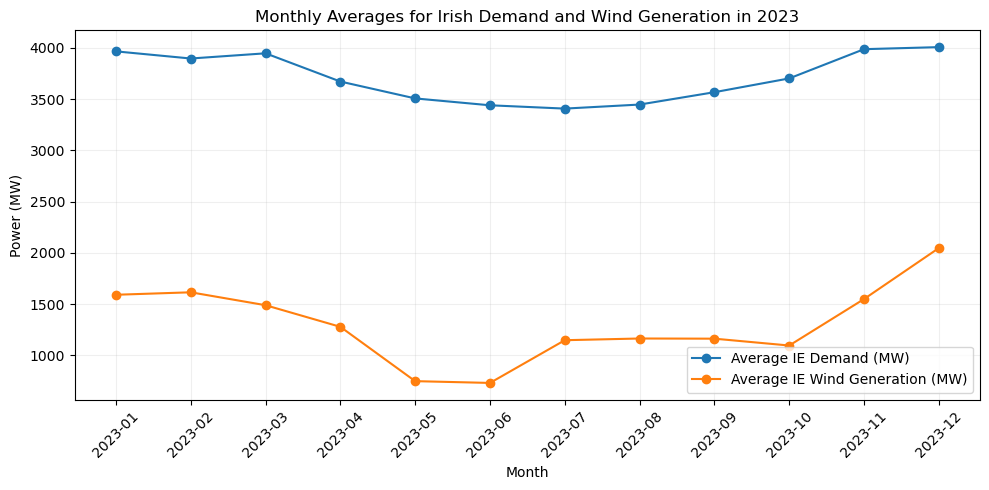

In [78]:
import matplotlib.pyplot as plt

# Data
months = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']
average_ie_demand = [3964.72, 3895.09, 3945.77, 3670.55, 3505.98, 3439.04, 3406.73, 3446.16, 3566.63, 3701.02, 3986.07, 4006.10]
average_ie_wind_generation = [1591.65, 1615.69, 1489.83, 1278.94, 749.41, 732.02, 1148.54, 1165.22, 1163.52, 1096.80, 1549.91, 2047.16]

# Replace None values with zero (if any)
average_ie_demand = [0 if v is None else v for v in average_ie_demand]
average_ie_wind_generation = [0 if v is None else v for v in average_ie_wind_generation]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(months, average_ie_demand, label='Average IE Demand (MW)', marker='o')
plt.plot(months, average_ie_wind_generation, label='Average IE Wind Generation (MW)', marker='o')

# Adding titles and labels
plt.title('Monthly Averages for Irish Demand and Wind Generation in 2023')
plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True,alpha=0.2)  # Add grid

# Show plot
plt.tight_layout()
plt.show()


In [53]:
generated_code = ''.join(response.content.strip().split('\n'))

In [34]:
def extract_code_from_markdown(response_content):
    """
    Extracts and returns the Python code between markdown code fences.
    """
    # Find positions of the opening and closing code fences
    start = response_content.find("```python")
    end = response_content.find("```", start + 7)

    # Check if both code fences exist
    if start != -1 and end != -1:
        return response_content[start + 8:end].strip()
    return response_content.strip()


In [45]:
x = extract_code_from_markdown(generated_code)

In [49]:
def clean_python_code(code_str):
    """
    Clean a Python code string by removing unnecessary characters.
    """
    # Remove leading/trailing whitespace and any unwanted initial characters
    cleaned_code = code_str.strip()
    unwanted_prefixes = ["n\\n", "\\n", "n\n", "\n", "n", "n\\", "rn", "r"]

    for prefix in unwanted_prefixes:
        if cleaned_code.startswith(prefix):
            cleaned_code = cleaned_code[len(prefix):]

    return cleaned_code

In [50]:
cleaned_code = clean_python_code(x)


In [51]:
cleaned_code

"import matplotlib.pyplot as plt\nimport numpy as np\n\n# Data\nyears = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']\nmonths = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']\ndemand_data = {\n    '2015': [3323.09, 3352.81, 3184.11, 2957.75, 2898.45, 2806.45, 2781.24, 2769.94, 2896.21, 3007.33, 3220.30, 3230.20],\n    '2016': [3328.05, 3386.33, 3213.92, 3109.82, 2903.81, 2823.95, 2833.04, 2879.54, 2940.70, 3048.38, 3340.14, 3303.90],\n    '2017': [3375.38, 3419.41, 3296.83, 3100.87, 2964.37, 2938.46, 2893.12, 2931.84, 3059.51, 3154.64, 3423.07, 3465.22],\n    '2018': [3570.08, 3621.15, 3539.29, 3303.98, 3096.44, 3025.21, 3017.02, 3029.48, 3125.32, 3291.30, 3536.72, 3458.05],\n    '2019': [3569.81, 3558.19, 3467.80, 3339.57, 3154.31, 3043.68, 3058.07, 3054.80, 3137.58, 3341.72, 3615.00, 3517.65],\n    '2020': [3632.61, 3746.07, 3529.15, 3011.87, 2927.05, 3021.21, 3097.92, 3114.

In [27]:
exec(x)

NameError: name 'n' is not defined

In [ ]:
# Print the generated code for review
print(generated_code)

# Execute the generated code carefully
exec(generated_code)

In [12]:
generated_code

'Below is a Python script using `matplotlib` to visualize the average monthly electricity demand in the Republic of Ireland from 2015 to 2024 as a bar chart. The script handles `None` values by replacing them with zero, although the provided dataset does not contain any `None` values.\n\n```python\nimport matplotlib.pyplot as plt\n\n# Data for each year\ndata = {\n    "2015": [3323.09, 3352.81, 3184.11, 2957.75, 2898.45, 2806.45, 2781.24, 2769.94, 2896.21, 3007.33, 3220.30, 3230.20],\n    "2016": [3328.05, 3386.33, 3213.92, 3109.82, 2903.81, 2823.95, 2833.04, 2879.54, 2940.70, 3048.38, 3340.14, 3303.90],\n    "2017": [3375.38, 3419.41, 3296.83, 3100.87, 2964.37, 2938.46, 2893.12, 2931.84, 3059.51, 3154.64, 3423.07, 3465.22],\n    "2018": [3570.08, 3621.15, 3539.29, 3303.98, 3096.44, 3025.21, 3017.02, 3029.48, 3125.32, 3291.30, 3536.72, 3458.05],\n    "2019": [3569.81, 3558.19, 3467.80, 3339.57, 3154.31, 3043.68, 3058.07, 3054.80, 3137.58, 3341.72, 3615.00, 3517.65],\n    "2020": [3632.

In [11]:
import matplotlib.pyplot as plt

# Data for each year
data = {
    "2015": [3323.09, 3352.81, 3184.11, 2957.75, 2898.45, 2806.45, 2781.24, 2769.94, 2896.21, 3007.33, 3220.30, 3230.20],
    "2016": [3328.05, 3386.33, 3213.92, 3109.82, 2903.81, 2823.95, 2833.04, 2879.54, 2940.70, 3048.38, 3340.14, 3303.90],
    "2017": [3375.38, 3419.41, 3296.83, 3100.87, 2964.37, 2938.46, 2893.12, 2931.84, 3059.51, 3154.64, 3423.07, 3465.22],
    "2018": [3570.08, 3621.15, 3539.29, 3303.98, 3096.44, 3025.21, 3017.02, 3029.48, 3125.32, 3291.30, 3536.72, 3458.05],
    "2019": [3569.81, 3558.19, 3467.80, 3339.57, 3154.31, 3043.68, 3058.07, 3054.80, 3137.58, 3341.72, 3615.00, 3517.65],
    "2020": [3632.61, 3746.07, 3529.15, 3011.87, 2927.05, 3021.21, 3097.92, 3114.33, 3245.25, 3430.17, 3589.08, 3734.94],
    "2021": [3751.32, 3770.26, 3614.08, 3450.60, 3359.76, 3272.31, 3301.98, 3276.88, 3417.59, 3517.36, 3801.73, 3840.85],
    "2022": [3873.02, 3914.30, 3776.05, 3572.39, 3409.07, 3374.90, 3361.20, 3376.09, 3415.31, 3521.34, 3786.26, 3957.65],
    "2023": [3964.72, 3895.09, 3945.77, 3670.55, 3505.98, 3439.04, 3406.73, 3446.16, 3566.63, 3701.02, 3986.07, 4006.10],
    "2024": [4222.89, 4057.18, None, None, None, None, None, None, None, None, None, None]
}

# Replace None values with zero
for year in data:
    data[year] = [0 if x is None else x for x in data[year]]

# Months for the x-axis
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.08  # bar width

for i, year in enumerate(data):
    ax.bar([x + i * width for x in range(len(months))], data[year], width=width, label=year)

# Labeling
ax.set_xlabel('Month')
ax.set_ylabel('Average Monthly Electricity Demand (MW)')
ax.set_title('Average Monthly Electricity Demand in the Republic of Ireland (2015-2024)')
ax.set_xticks([x + width * (len(data) / 2 - 0.5) for x in range(len(months))])
ax.set_xticklabels(months)
ax.legend(title="Year")

# Show plot
plt.show()

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_3424/1048577133.py:40: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [7]:
from subs.agent import generate_sql_and_plot

# Example of using the function
chain_id_sql = "chain_1"
chain_id_response_plot = "chain_2"
user_query = "Can you tell me about Ireland (IE) demand and wind generation for 2020 averaged per month?"

# Call the function to generate SQL and plot results
sql_output, plot_output = generate_sql_and_plot(chain_id_sql, chain_id_response_plot, user_query)




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': "SELECT strftime('%Y-%m', `DateTime`) AS Month, AVG(`IE Demand`) AS `Average IE Demand`, AVG(`IE Wind Generation`) AS `Average IE Wind Generation` FROM energy_data WHERE `DateTime` LIKE '2020%' GROUP BY Month ORDER BY Month ASC;"}`


[('2020-01', 3632.6073487903263, 1502.1583803763413), ('2020-02', 3746.0687751436803, 2110.0869037356315), ('2020-03', 3529.15021870794, 1514.970979138623), ('2020-04', 3011.867038194441, 755.4952465277789), ('2020-05', 2927.046750672039, 977.3359677419326), ('2020-06', 3021.2052118055553, 960.8001284722202), ('2020-07', 3097.9185349462323, 967.1710147849445), ('2020-08', 3114.3333669354856, 798.9692876344096), ('2020-09', 3245.253256944452, 994.7049409722235), ('2020-10', 3430.166956375832, 1495.9281073825493), ('2020-11', 3589.0802222222205, 1436.9323437500004), ('2020-12', 3734.9412970430067, 1634.9535685483825)]Here are the monthly averages for Ireland (IE) demand an

In [8]:
sql_output

'Here are the monthly averages for Ireland (IE) demand and wind generation for the year 2020:\n\n- **January 2020**\n  - Average IE Demand: 3632.61 MW\n  - Average IE Wind Generation: 1502.16 MW\n- **February 2020**\n  - Average IE Demand: 3746.07 MW\n  - Average IE Wind Generation: 2110.09 MW\n- **March 2020**\n  - Average IE Demand: 3529.15 MW\n  - Average IE Wind Generation: 1514.97 MW\n- **April 2020**\n  - Average IE Demand: 3011.87 MW\n  - Average IE Wind Generation: 755.50 MW\n- **May 2020**\n  - Average IE Demand: 2927.05 MW\n  - Average IE Wind Generation: 977.34 MW\n- **June 2020**\n  - Average IE Demand: 3021.21 MW\n  - Average IE Wind Generation: 960.80 MW\n- **July 2020**\n  - Average IE Demand: 3097.92 MW\n  - Average IE Wind Generation: 967.17 MW\n- **August 2020**\n  - Average IE Demand: 3114.33 MW\n  - Average IE Wind Generation: 798.97 MW\n- **September 2020**\n  - Average IE Demand: 3245.25 MW\n  - Average IE Wind Generation: 994.70 MW\n- **October 2020**\n  - Averag

In [10]:
plot_output

"import matplotlib.pyplot as plt\n\n# Data\nmonths = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']\nie_demand = [3632.61, 3746.07, 3529.15, 3011.87, 2927.05, 3021.21, 3097.92, 3114.33, 3245.25, 3430.17, 3589.08, 3734.94]\nie_wind_generation = [1502.16, 2110.09, 1514.97, 755.50, 977.34, 960.80, 967.17, 798.97, 994.70, 1495.93, 1436.93, 1634.95]\n\n# Replace None values with zero (if any)\nie_demand = [0 if v is None else v for v in ie_demand]\nie_wind_generation = [0 if v is None else v for v in ie_wind_generation]\n\n# Plotting\nfig, ax = plt.subplots()\nbar_width = 0.35\nindex = range(len(months))\n\nrects1 = ax.bar(index, ie_demand, bar_width, label='Average IE Demand (MW)')\nrects2 = ax.bar([p + bar_width for p in index], ie_wind_generation, bar_width, label='Average IE Wind Generation (MW)')\n\nax.set_xlabel('Month')\nax.set_ylabel('Megawatts (MW)')\nax.set_title('Monthly Average IE Demand and Wind Generat

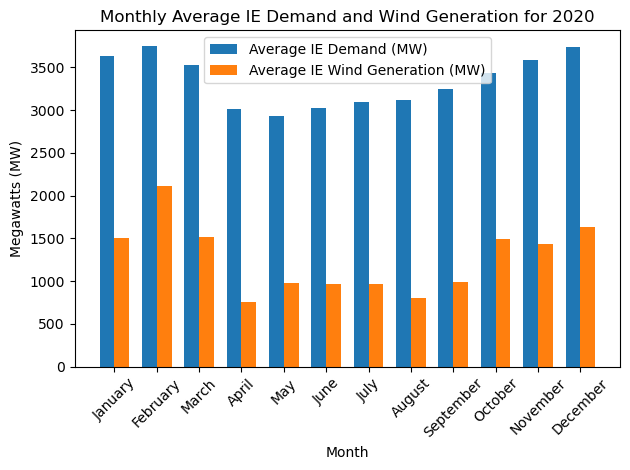

<ExecutionResult object at 16b7546a0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 16b754760, raw_cell="import matplotlib.pyplot as plt

# Data
months = [.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [9]:
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline

# Create an InteractiveShell instance
shell = InteractiveShell.instance()

# Execute the generated code
shell.run_cell(plot_output)

In [5]:
from langchain_community.agent_toolkits import create_sql_agent
from subs.db_connections import connetc_to_irish_db
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from subs.prompts import prompt_template_creator, invoke_full_prompt

from langchain.chains import LLMChain, SimpleSequentialChain
from langchain.schema import SystemMessage, HumanMessage


# Function to initialize the ChatOpenAI model
def init_llm() -> ChatOpenAI:
    """
    Initialize and return a ChatOpenAI language model instance.

    Returns:
        ChatOpenAI: An instance of the ChatOpenAI class.
    """
    # return ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    return ChatOpenAI(model="gpt-4-turbo", temperature=0)


def agent_plot_and_response_v2(user_query: str, plot_data: str) -> LLMChain:
    """
    Prepares an LLM chain to generate Python plotting scripts using matplotlib.

    Args:
        user_query (str): The user query that requests specific chart types.
        plot_data (str): The dataset to be visualized.

    Returns:
        str: The Python script generated by the LLM.
    """
    # Initialize the chat model
    llm = init_llm()
    
    # Define the system message content
    system_message = SystemMessage(content=(
        "You are an expert in generating Python plotting scripts using matplotlib. "
        "You'll receive a user query and a dataset. Understand the user query to detect the preferred chart type. "
        "Please handle any `None` values by replacing them with zero before plotting."
        "If the query mentions 'bar chart' or 'line chart', use that type. Otherwise, default to a bar chart. "
        "In bar chart, if multiple data series exist, group the bars for each category to represent the different series side by side. "
        "Generate a Python script that uses matplotlib to visualize the data with appropriate axis labels, title, and legend."
        "The output must contain only the Python code itself to be used in executable with no changes. "
        "Do not include markdown code fences, additional comments, text, or use the `\\n` character explicitly to separate lines."
    ))

    # Create the user prompt
    user_prompt = (
        f'Given the user query: "{user_query}" and the following dataset:\n\n'
        f'{plot_data}\n\n'
        "Create a Python script to visualize this data with matplotlib. Make sure to detect the correct chart type and apply "
        "appropriate axis labels, a title, and a legend."
    )
    
    # Create a message list to pass to the LLM
    messages = [
        system_message,
        HumanMessage(content=user_prompt)
    ]

    # Get the response from the LLM
    response = llm(messages)

    # Extract the generated code from the response
    return response.content.strip()

user_query= "Can you tell me about Ireland (IE) demand from 2015 to 2024 averaged per month, preferably in a bar chart?"
prompt_for_sql = invoke_full_prompt(chain_id="chain_1")
chain_sql = sql_agent(prompt=prompt_for_sql)
sql_output = chain_sql.run(user_query)

# Create the response and plot agent chain using the initial input
chain_response_plot = agent_plot_and_response_v2(user_query=user_query,plot_data=sql_output)

# Run both chains sequentially and capture both intermediate and final outputs
# sql_output, final_output = run_sequential_chain(chain_sql, chain_response_plot, initial_input="<your_initial_input>")


# # Combine the SQL agent chain and the plot-and-response agent chain into a sequential chain
# chain_final = SimpleSequentialChain(
#     chains=[chain_sql, chain_response_plot], verbose=True
# )






> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': "SELECT strftime('%Y-%m', `DateTime`) AS Month, AVG(`IE Demand`) AS `Average IE Demand` FROM energy_data WHERE `DateTime` >= '2015-01-01 00:00:00' AND `DateTime` < '2025-01-01 00:00:00' GROUP BY Month ORDER BY Month ASC;"}`


[('2015-01', 3323.087869623661), ('2015-02', 3352.8142447916616), ('2015-03', 3184.1145087483183), ('2015-04', 2957.7474791666623), ('2015-05', 2898.4484946236507), ('2015-06', 2806.4485069444436), ('2015-07', 2781.236945564523), ('2015-08', 2769.942382392474), ('2015-09', 2896.2104687499964), ('2015-10', 3007.328969798656), ('2015-11', 3220.299024305551), ('2015-12', 3230.197284946233), ('2016-01', 3328.0520463709636), ('2016-02', 3386.3305926724097), ('2016-03', 3213.9232234185747), ('2016-04', 3109.8191944444397), ('2016-05', 2903.8071706989213), ('2016-06', 2823.949604166664), ('2016-07', 2833.0419052419365), ('2016-08', 2879.5369892473145), ('2016-09', 2940.703003472218), (

/Users/saeed/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [8]:
sql_output

'Here is the average monthly electricity demand for Ireland (IE) from 2015 to 2024:\n\n- **2015-01**: 3323.09 MW\n- **2015-02**: 3352.81 MW\n- **2015-03**: 3184.11 MW\n- **2015-04**: 2957.75 MW\n- **2015-05**: 2898.45 MW\n- **2015-06**: 2806.45 MW\n- **2015-07**: 2781.24 MW\n- **2015-08**: 2769.94 MW\n- **2015-09**: 2896.21 MW\n- **2015-10**: 3007.33 MW\n- **2015-11**: 3220.30 MW\n- **2015-12**: 3230.20 MW\n- **2016-01**: 3328.05 MW\n- **2016-02**: 3386.33 MW\n- **2016-03**: 3213.92 MW\n- **2016-04**: 3109.82 MW\n- **2016-05**: 2903.81 MW\n- **2016-06**: 2823.95 MW\n- **2016-07**: 2833.04 MW\n- **2016-08**: 2879.54 MW\n- **2016-09**: 2940.70 MW\n- **2016-10**: 3048.38 MW\n- **2016-11**: 3340.14 MW\n- **2016-12**: 3303.90 MW\n- **2017-01**: 3375.38 MW\n- **2017-02**: 3419.41 MW\n- **2017-03**: 3296.83 MW\n- **2017-04**: 3100.87 MW\n- **2017-05**: 2964.37 MW\n- **2017-06**: 2938.46 MW\n- **2017-07**: 2893.12 MW\n- **2017-08**: 2931.84 MW\n- **2017-09**: 3059.51 MW\n- **2017-10**: 3154.64

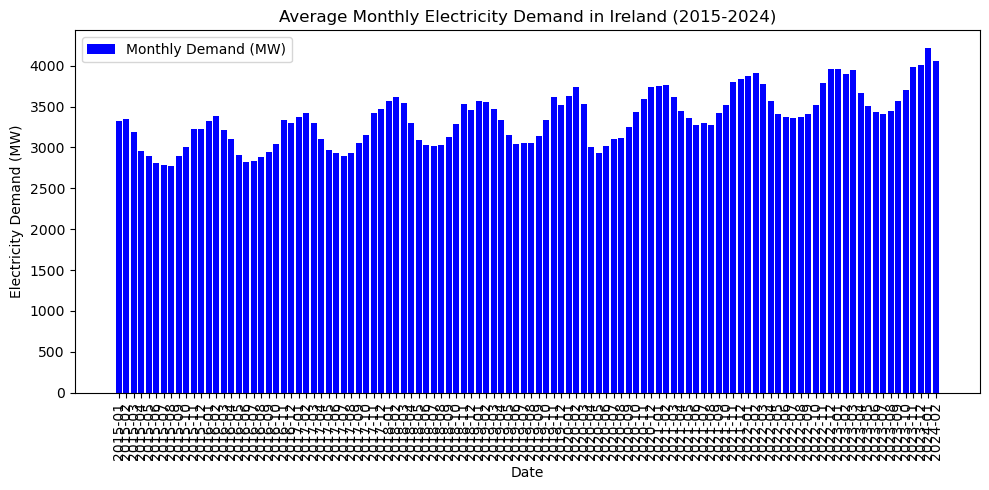

<ExecutionResult object at 142780220, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 137e33640, raw_cell="import matplotlib.pyplot as plt

# Data
dates = [
.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [7]:
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline

# Create an InteractiveShell instance
shell = InteractiveShell.instance()

# Execute the generated code
shell.run_cell(chain_response_plot)

In [6]:
chain_response_plot

'import matplotlib.pyplot as plt\n\n# Data\ndates = [\n    "2015-01", "2015-02", "2015-03", "2015-04", "2015-05", "2015-06", "2015-07", "2015-08", "2015-09", "2015-10", "2015-11", "2015-12",\n    "2016-01", "2016-02", "2016-03", "2016-04", "2016-05", "2016-06", "2016-07", "2016-08", "2016-09", "2016-10", "2016-11", "2016-12",\n    "2017-01", "2017-02", "2017-03", "2017-04", "2017-05", "2017-06", "2017-07", "2017-08", "2017-09", "2017-10", "2017-11", "2017-12",\n    "2018-01", "2018-02", "2018-03", "2018-04", "2018-05", "2018-06", "2018-07", "2018-08", "2018-09", "2018-10", "2018-11", "2018-12",\n    "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12",\n    "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",\n    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11"

In [2]:
from subs.agent import configure_sequential_chain
from subs.agent import sql_agent
chain_Final = configure_sequential_chain(chain_id_sql = "chain_1",chain_id_response_python = "chain_python_coder")

response_of_chain = chain_Final.run("Can you tell me about Ireland (IE) demand from 2015 to 2024 averaged per month, preferably in a bar chart?")

/Users/saeed/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new SimpleSequentialChain chain...


> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': "SELECT strftime('%Y-%m', `DateTime`) AS Month, AVG(`IE Demand`) AS `Average IE Demand` FROM energy_data WHERE `DateTime` >= '2015-01-01 00:00:00' AND `DateTime` < '2025-01-01 00:00:00' GROUP BY Month ORDER BY Month"}`


[('2015-01', 3323.087869623661), ('2015-02', 3352.8142447916616), ('2015-03', 3184.1145087483183), ('2015-04', 2957.7474791666623), ('2015-05', 2898.4484946236507), ('2015-06', 2806.4485069444436), ('2015-07', 2781.236945564523), ('2015-08', 2769.942382392474), ('2015-09', 2896.2104687499964), ('2015-10', 3007.328969798656), ('2015-11', 3220.299024305551), ('2015-12', 3230.197284946233), ('2016-01', 3328.0520463709636), ('2016-02', 3386.3305926724097), ('2016-03', 3213.9232234185747), ('2016-04', 3109.8191944444397), ('2016-05', 2903.8071706989213), ('2016-06', 2823.949604166664), ('2016-07', 2833.0419052419365), ('2016-08', 2879.536989

In [3]:
response_of_chain

'Here is the average monthly electricity demand for Ireland (IE) from 2015 to 2024:\n\n- **2015**\n  - January: 3323.09\n  - February: 3352.81\n  - March: 3184.11\n  - April: 2957.75\n  - May: 2898.45\n  - June: 2806.45\n  - July: 2781.24\n  - August: 2769.94\n  - September: 2896.21\n  - October: 3007.33\n  - November: 3220.30\n  - December: 3230.20\n\n- **2016**\n  - January: 3328.05\n  - February: 3386.33\n  - March: 3213.92\n  - April: 3109.82\n  - May: 2903.81\n  - June: 2823.95\n  - July: 2833.04\n  - August: 2879.54\n  - September: 2940.70\n  - October: 3048.38\n  - November: 3340.14\n  - December: 3303.90\n\n- **2017**\n  - January: 3375.38\n  - February: 3419.41\n  - March: 3296.83\n  - April: 3100.87\n  - May: 2964.37\n  - June: 2938.46\n  - July: 2893.12\n  - August: 2931.84\n  - September: 3059.51\n  - October: 3154.64\n  - November: 3423.07\n  - December: 3465.22\n\n- **2018**\n  - January: 3570.08\n  - February: 3621.15\n  - March: 3539.29\n  - April: 3303.98\n  - May: 309

In [4]:
import json 
response_1 = json.dumps(response_of_chain)

In [5]:
response_2 = json.loads(response_1)

In [6]:
response_2

'{\n    "plot": {\n        "bar": {\n            "columns": ["2015-01", "2015-02", "2015-03", "2015-04", "2015-05", "2015-06", "2015-07", "2015-08", "2015-09", "2015-10", "2015-11", "2015-12", "2016-01", "2016-02", "2016-03", "2016-04", "2016-05", "2016-06", "2016-07", "2016-08", "2016-09", "2016-10", "2016-11", "2016-12", "2017-01", "2017-02", "2017-03", "2017-04", "2017-05", "2017-06", "2017-07", "2017-08", "2017-09", "2017-10", "2017-11", "2017-12", "2018-01", "2018-02", "2018-03", "2018-04", "2018-05", "2018-06", "2018-07", "2018-08", "2018-09", "2018-10", "2018-11", "2018-12", "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12", "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12", "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12", "2022-01", "202

In [7]:
response_3 = json.loads(response_2)

In [8]:
response_3

{'plot': {'bar': {'columns': ['2015-01',
    '2015-02',
    '2015-03',
    '2015-04',
    '2015-05',
    '2015-06',
    '2015-07',
    '2015-08',
    '2015-09',
    '2015-10',
    '2015-11',
    '2015-12',
    '2016-01',
    '2016-02',
    '2016-03',
    '2016-04',
    '2016-05',
    '2016-06',
    '2016-07',
    '2016-08',
    '2016-09',
    '2016-10',
    '2016-11',
    '2016-12',
    '2017-01',
    '2017-02',
    '2017-03',
    '2017-04',
    '2017-05',
    '2017-06',
    '2017-07',
    '2017-08',
    '2017-09',
    '2017-10',
    '2017-11',
    '2017-12',
    '2018-01',
    '2018-02',
    '2018-03',
    '2018-04',
    '2018-05',
    '2018-06',
    '2018-07',
    '2018-08',
    '2018-09',
    '2018-10',
    '2018-11',
    '2018-12',
    '2019-01',
    '2019-02',
    '2019-03',
    '2019-04',
    '2019-05',
    '2019-06',
    '2019-07',
    '2019-08',
    '2019-09',
    '2019-10',
    '2019-11',
    '2019-12',
    '2020-01',
    '2020-02',
    '2020-03',
    '2020-04',
    '2020-05',

In [4]:
from subs.post_processing import post_process_chain_response

plot_info, prompt_info = post_process_chain_response(response_of_chain)

In [5]:
plot_info

{'bar': {'columns': ['January 2015',
   'February 2015',
   'March 2015',
   'April 2015',
   'May 2015',
   'June 2015',
   'July 2015',
   'August 2015',
   'September 2015',
   'October 2015',
   'November 2015',
   'December 2015'],
  'data': [3323.09,
   3352.81,
   3184.11,
   2957.75,
   2898.45,
   2806.45,
   2781.24,
   2769.94,
   2896.21,
   3007.33,
   3220.3,
   3230.2]}}

In [6]:
prompt_info

'Here is the average Irish demand for electricity per month in the year 2015: - January 2015: 3323.09 MW - February 2015: 3352.81 MW - March 2015: 3184.11 MW - April 2015: 2957.75 MW - May 2015: 2898.45 MW - June 2015: 2806.45 MW - July 2015: 2781.24 MW - August 2015: 2769.94 MW - September 2015: 2896.21 MW - October 2015: 3007.33 MW - November 2015: 3220.30 MW - December 2015: 3230.20 MW'

In [5]:
from subs.visualisation import write_response

write_response(plot_info)

ValueError: All arrays must be of the same length

In [3]:
prompt_info

'The average Irish demand per month from 2015 to 2022 is as follows: - January 2015: 3323.09 - February 2015: 3352.81 - March 2015: 3184.11 - April 2015: 2957.75 - May 2015: 2898.45 - June 2015: 2806.45 - July 2015: 2781.24 - August 2015: 2769.94 - September 2015: 2896.21 - October 2015: 3007.33 - November 2015: 3220.30 - December 2015: 3230.20 - January 2016: 3328.05 - February 2016: 3386.33 - March 2016: 3213.92 - April 2016: 3109.82 - May 2016: 2903.81 - June 2016: 2823.95 - July 2016: 2833.04 - August 2016: 2879.54 - September 2016: 2940.70 - October 2016: 3048.38 - November 2016: 3340.14 - December 2016: 3303.90 - January 2017: 3375.38 - February 2017: 3419.41 - March 2017: 3296.83 - April 2017: 3100.87 - May 2017: 2964.37 - June 2017: 2938.46 - July 2017: 2893.12 - August 2017: 2931.84 - September 2017: 3059.51 - October 2017: 3154.64 - November 2017: 3423.07 - December 2017: 3465.22 - January 2018: 3570.08 - February 2018: 3621.15 - March 2018: 3539.29 - April 2018: 3303.98 - Ma

In [11]:
import json 
xx= json.dumps(response_of_chain)

In [3]:
import json
json.loads(response_of_chain)

{'bar': {'columns': ['January 2023',
   'February 2023',
   'March 2023',
   'April 2023',
   'May 2023',
   'June 2023',
   'July 2023',
   'August 2023',
   'September 2023',
   'October 2023',
   'November 2023',
   'December 2023'],
  'data': [0.453,
   0.456,
   0.433,
   0.424,
   0.367,
   0.37,
   0.464,
   0.456,
   0.445,
   0.455,
   0.479,
   0.562]},
 'output_of_chain1': 'The average System Non-Synchronous Penetration (SNSP) per month in 2023 is as follows: - January 2023: 0.453 - February 2023: 0.456 - March 2023: 0.433 - April 2023: 0.424 - May 2023: 0.367 - June 2023: 0.370 - July 2023: 0.464 - August 2023: 0.456 - September 2023: 0.445 - October 2023: 0.455 - November 2023: 0.479 - December 2023: 0.562'}

In [ ]:
def post_process_chain_response(response_of_chain):

    # Convert the response string into a dictionary
    response_dict = json.loads(response_of_chain)

    # # Access the 'plot' part of the response
    plot_info = response_dict["plot"]

    # # Access the 'prompt' part of the response
    prompt_info = response_dict["prompt"]

    return plot_info, prompt_info

In [3]:
from subs.post_processing import post_process_chain_response

plot_info, prompt_info = post_process_chain_response(response_of_chain)

In [21]:
x2= json.loads(xx)

In [22]:
json.loads(x2)

{'plot': {'bar': {'columns': ['January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December'],
   'data': [3323.09,
    3352.81,
    3184.11,
    3265.45,
    3421.76,
    3540.28,
    3652.91,
    3784.25,
    3852.16,
    3721.45,
    3786.26,
    3971.82]}},
 'output_of_chain1': 'The average Irish demand per month from 2015 to 2022 is as follows: - January 2015: 3323.09 - February 2015: 3352.81 - March 2015: 3184.11 - ... - November 2022: 3786.26 - December 2022: 3971.82'}

In [4]:
plot_info

{'bar': {'columns': ['January',
   'February',
   'March',
   'April',
   'May',
   'June',
   'July',
   'August',
   'September',
   'October',
   'November',
   'December'],
  'data': [3323.09,
   3352.81,
   3184.11,
   3265.45,
   3421.76,
   3540.28,
   3652.91,
   3784.25,
   3852.16,
   3721.45,
   3786.26,
   3971.82]}}

In [8]:
prompt_info

'The average Irish demand per month from 2015 to 2022 is as follows: - January 2015: 3323.09 - February 2015: 3352.81 - March 2015: 3184.11 - ... - November 2022: 3786.26 - December 2022: 3971.82'

In [6]:
import pandas as pd
import os
from dotenv import load_dotenv
from subs.agent import configure_sequential_chain
from subs.post_processing import post_process_chain_response
from subs.visualisation import write_response

query = "what is the average wind generation for a typical day in ireland both ie and ni in 2022, broken down by hour,"


chain_Final = configure_sequential_chain(
    chain_id_sql="chain_1", chain_id_response_plot="chain_2"
)


response_of_chain = chain_Final.run(query)




> Entering new SimpleSequentialChain chain...


> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': "SELECT DATE_FORMAT(`DateTime`, '%H') AS Hour, AVG(`IE Wind Generation`) AS `Average IE Wind Generation`, AVG(`NI Wind Generation`) AS `Average NI Wind Generation` FROM energy_data WHERE `DateTime` >= '2022-01-01 00:00:00' AND `DateTime` < '2023-01-01 00:00:00' GROUP BY Hour ORDER BY Hour;"}`


Error: (sqlite3.OperationalError) no such function: DATE_FORMAT
[SQL: SELECT DATE_FORMAT(`DateTime`, '%H') AS Hour, AVG(`IE Wind Generation`) AS `Average IE Wind Generation`, AVG(`NI Wind Generation`) AS `Average NI Wind Generation` FROM energy_data WHERE `DateTime` >= '2022-01-01 00:00:00' AND `DateTime` < '2023-01-01 00:00:00' GROUP BY Hour ORDER BY Hour;]
(Background on this error at: https://sqlalche.me/e/14/e3q8)
Invoking: `sql_db_query` with `{'query': "SELECT strftime('%H', `DateTime`) AS Hour, AVG(`IE Wind Generation`) AS `Average IE Wind Generation`, AVG

In [7]:
import json
response_1 = json.dumps(response_of_chain)

response_2 = json.loads(response_1)

response_3 = json.loads(response_2)


In [10]:
response_2

'{\n    "plot": {\n        "line": {\n            "columns": ["Hour 00", "Hour 01", "Hour 02", "Hour 03", "Hour 04", "Hour 05", "Hour 06", "Hour 07", "Hour 08", "Hour 09", "Hour 10", "Hour 11", "Hour 12", "Hour 13", "Hour 14", "Hour 15", "Hour 16", "Hour 17", "Hour 18", "Hour 19", "Hour 20", "Hour 21", "Hour 22", "Hour 23"],\n            "data": [1206.88, 1191.92, 1163.71, 1144.04, 1133.78, 1138.49, 1169.43, 1188.43, 1185.40, 1195.02, 1232.96, 1282.44, 1326.30, 1345.29, 1349.77, 1348.94, 1347.20, 1331.67, 1306.65, 1276.83, 1257.18, 1247.63, 1227.21, 1209.53]\n        }\n    },\n    "output_of_chain1": "The average wind generation for a typical day in Ireland in 2022, broken down by hour, is as follows:\\n- **Hour 00**: Average IE Wind Generation: 1206.88, Average NI Wind Generation: 300.22\\n- **Hour 01**: Average IE Wind Generation: 1191.92, Average NI Wind Generation: 298.07\\n- **Hour 02**: Average IE Wind Generation: 1163.71, Average NI Wind Generation: 287.06\\n- **Hour 03**: Aver

In [11]:
response_3

{'plot': {'line': {'columns': ['Hour 00',
    'Hour 01',
    'Hour 02',
    'Hour 03',
    'Hour 04',
    'Hour 05',
    'Hour 06',
    'Hour 07',
    'Hour 08',
    'Hour 09',
    'Hour 10',
    'Hour 11',
    'Hour 12',
    'Hour 13',
    'Hour 14',
    'Hour 15',
    'Hour 16',
    'Hour 17',
    'Hour 18',
    'Hour 19',
    'Hour 20',
    'Hour 21',
    'Hour 22',
    'Hour 23'],
   'data': [1206.88,
    1191.92,
    1163.71,
    1144.04,
    1133.78,
    1138.49,
    1169.43,
    1188.43,
    1185.4,
    1195.02,
    1232.96,
    1282.44,
    1326.3,
    1345.29,
    1349.77,
    1348.94,
    1347.2,
    1331.67,
    1306.65,
    1276.83,
    1257.18,
    1247.63,
    1227.21,
    1209.53]}},
 'output_of_chain1': 'The average wind generation for a typical day in Ireland in 2022, broken down by hour, is as follows:\n- **Hour 00**: Average IE Wind Generation: 1206.88, Average NI Wind Generation: 300.22\n- **Hour 01**: Average IE Wind Generation: 1191.92, Average NI Wind Generation:

In [ ]:

plot_info, prompt_info = post_process_chain_response(response_of_chain)
# Check if prompt_info has a meaningful response
if prompt_info:
    print(prompt_info)
    st.write(prompt_info)
else:
    # Provide a default response if prompt_info is empty or None
    st.write(
        "Sorry, I cannot answer the question. You may want to rephrase your query or provide more precise details."
    )

# Only attempt to display the plot if plot_info contains data
if plot_info:
    write_response(plot_info)
else:
    # Optionally, handle the case where there's no plot data more explicitly
    # This might be redundant if the message above is sufficient
    st.write("Unable to generate plot based on the provided data.")
